In [1]:
# --> Install necessary packages
!pip install --quiet -U "wandb" "lightning" "ptflops"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import time
import random
import wandb
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchmetrics import Accuracy, F1Score
from torchmetrics import MetricCollection
from PIL import Image
from torchvision import transforms as T, datasets
from types import SimpleNamespace
from torch.utils.data import random_split, DataLoader, Dataset
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger, CSVLogger
from lightning.pytorch import LightningDataModule
from sklearn.model_selection import train_test_split
from kaggle_secrets import UserSecretsClient
from ptflops import get_model_complexity_info

In [3]:
L.seed_everything(42)
NUM_WORKERS = os.cpu_count()

# Testing dataset
# DATASET_NORMAL_PATH= "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_normal-20251113T104849Z-1-001/cnn_dataset_normal/train"
# DATASET_UNDERSAMPLING_PATH= "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_undersampling-20251113T104849Z-1-001/cnn_dataset_undersampling/train"

# Should be adjusted for the end-to-end experiment
DATASET_NORMAL_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_normal/train"
DATASET_UNDERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_undersampling/train"
DATASET_OVERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_oversampling/train"

Seed set to 42


### WOrktable

In [4]:
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [5]:
class DAiSEECDM(L.LightningDataModule):
    def __init__(self, 
                 data_dir: str = None,
                 batch_size: int = 32,
                 num_workers: int = 4,
                 val_split: float = 0.2,
                 img_size: int = 32,
                 seed:int = 42):
        
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.img_size = img_size

        self.test_transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.train_transform = T.Compose([
            T.Resize((224, 224)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),
            T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
            T.RandomApply([T.RandomGrayscale(p=1.0)], p=0.1),
            T.RandomAffine(
                degrees=3, 
                translate=(0.05, 0.05),
                scale=(0.95, 1.05),
                shear=None
            ),
            T.RandomPerspective(distortion_scale=0.05, p=0.3),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        self.full_dataset = datasets.ImageFolder(self.data_dir)
        self.paths = [sample[0] for sample in self.full_dataset.imgs]
        self.labels = [sample[1] for sample in self.full_dataset.imgs]

        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            self.paths, self.labels, test_size=0.2, stratify=self.labels, random_state=42
        )
        
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
        )
            
        if stage == "fit":
            self.train_dataset = ImagePathDataset(train_paths, train_labels, transform=self.train_transform)
            self.val_dataset = ImagePathDataset(val_paths, val_labels, transform=self.test_transform)
            
        if stage == "test":
            self.test_dataset = ImagePathDataset(test_paths, test_labels, transform=self.test_transform)
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, pin_memory=True,num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True,num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, pin_memory=True,num_workers=self.num_workers)

In [6]:
dm_normal = DAiSEECDM(data_dir=DATASET_NORMAL_PATH)
dm_under = DAiSEECDM(data_dir=DATASET_UNDERSAMPLING_PATH)
dm_over = DAiSEECDM(data_dir=DATASET_OVERSAMPLING_PATH)

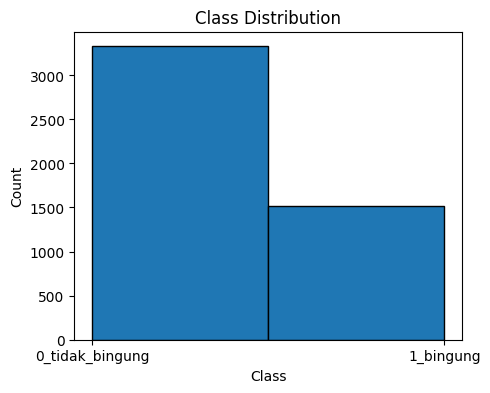

In [7]:
# Cheking sanity
dm = dm_normal
dm.prepare_data()
dm.setup(stage="fit")
class_names = dm.full_dataset.classes

# print(f"Train size: {len(dm.train_dataset)}")
# print(f"Val size: {len(dm.val_dataset)}")
# print(f"Num of classes: {len(class_names)}\nClasses: {class_names}")
# print(f"Classes: {dm.train_dataset.labels[:10]}")  # Should be 0s and 1s

# train_loader = dm.train_dataloader()
# # val_loader = dm.val_dataloader()

# batch = next(iter(train_loader))
# print(type(batch), len(batch))
# print(batch[0].shape, batch[1].shape)


# imgs, labels = next(iter(dm.train_dataloader()))
# print(imgs.mean(), imgs.std())

plt.figure(figsize=(5, 4))
plt.hist(dm.labels, bins=len(class_names), edgecolor='black')
plt.xticks(np.arange(len(class_names)), class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

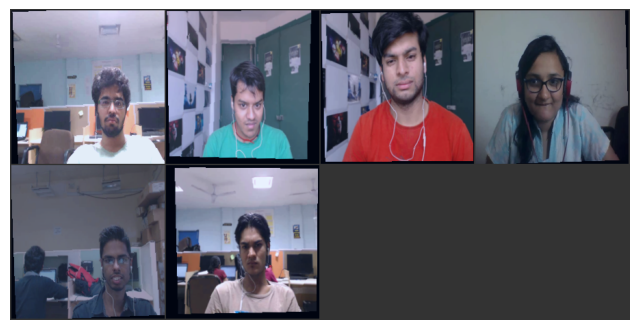

In [8]:
NUM_IMGS = 6
images = torch.stack([dm.train_dataset[idx][0] for idx in range(NUM_IMGS)])
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.2)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))
# plt.title(class_names[labels])
plt.axis("off")
plt.show()

## Model Initialization

In [9]:
class EEffModelTF(nn.Module):
    def __init__(self, num_classes=2, c_t=512, act_fn=nn.SiLU, dropout=0.2):
        super().__init__()
        self.base = torchvision.models.efficientnet_b0(weights='DEFAULT')
        self.base.classifier = nn.Identity() # --> acts as a placeholder that effectively "removes" a layer's functionality while maintaining the structural integrity of the nn.Module hierarchy
        self.fc = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(1280, c_t),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_t,c_t//2),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_t//2,num_classes),
        )

    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

In [10]:
class DCDModule(L.LightningModule):
    def __init__(self,
                 model_name: str,
                 model_hparams: dict,
                 optimizer_name: str,
                 optimizer_hparams: dict):
        super().__init__()
        self.save_hyperparameters(ignore=['large_object']) if hasattr(self, 'save_hyperparameters') else None
        self.model = EEffModelTF(**model_hparams)

        self.task = "binary"
        self.num_classes = None if self.task == "binary" else model_hparams.get('num_classes')
        self.loss_fn = nn.BCEWithLogitsLoss() if self.task == "binary" else nn.CrossEntropyLoss()
        metric_args = {"task": self.task, "num_classes": self.num_classes}
        self.metrics = MetricCollection({
            "train_acc": Accuracy(**metric_args),
            "val_acc": Accuracy(**metric_args),
            "val_f1": F1Score(**metric_args, average='macro'),
            "test_acc": Accuracy(**metric_args),
            "test_f1_macro": F1Score(**metric_args, average='macro'),
            "test_f1_weighted": F1Score(**metric_args, average='weighted'),
        })
        
    def on_fit_start(self):
        self.metrics = self.metrics.to(self.device)

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), **self.hparams.optimizer_hparams)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1, patience=10
            ),
            "monitor": "val_loss", 
        }
        return [optimizer], [scheduler]

    def _process_batch(self, batch):
        x, y = batch
        if self.task == "binary":
            y = y.float().unsqueeze(1)
        probs = self(x)
        return x, y , probs

    def _shared_step(self, batch, step_type: str):
        """Shared logic for training/validation/test steps"""
        x, y, preds = self._process_batch(batch)
        loss = self.loss_fn(preds, y)
        
        self.log(f"{step_type}_loss", loss, prog_bar=True)
        
        # Log metrics for validation and test
        if step_type in ["val", "test"]:
            acc = self.metrics[f"{step_type}_acc"](preds, y)
            self.log(f"{step_type}_acc", acc, prog_bar=True)
            
            if step_type == "val":
                f1 = self.metrics["val_f1"](preds, y)
                self.log("val_f1", f1, prog_bar=True)
            else:  # test
                f1_macro = self.metrics["test_f1_macro"](preds, y)
                f1_weighted = self.metrics["test_f1_weighted"](preds, y)
                self.log("test_f1_macro", f1_macro)
                self.log("test_f1_weighted", f1_weighted)
        
        return loss if step_type == "train" else None

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")
    
    def test_step(self, batch, batch_idx):
        self._shared_step(batch, "test")

In [11]:
def train_experiment(model_name, 
                     dataset_name, 
                     optimizer_name, 
                     model_hparams, 
                     optimizer_hparams,
                     data_module,
                     seed=42,
                     max_epochs=100):
    
    L.seed_everything(seed)
    experiment_name = f"{model_name}_{dataset_name}_{optimizer_name}_seed{seed}"
    try:
        logger = WandbLogger(
            offline=True,
            name=experiment_name,
            project="ACRIG-DAiSEE-confusion_detection",
            config={
                "model_name": model_name,
                "dataset_name": dataset_name,
                "optimizer_name": optimizer_name,
                "model_hparams": model_hparams,
                "optimizer_hparams": optimizer_hparams,
                "seed": seed,
                "max_epochs": max_epochs,
            },
        )
        print("WandB logger initialized successfully")
    except Exception as e:
        print(f"WandB Logger failed: {e}")
        print("Falling back to CSV logger")
        logger = CSVLogger(
            save_dir="logs",
            name=experiment_name
        )

    model = DCDModule(
        model_name=model_name,
        model_hparams=model_hparams,
        optimizer_name=optimizer_name,
        optimizer_hparams=optimizer_hparams
    )
    
    trainer = L.Trainer(
        default_root_dir=f"checkpoints/{experiment_name}",
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        logger=logger,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, 
                mode="max", 
                monitor="val_acc",
                dirpath=f"checkpoints/{experiment_name}",
                filename="best-checkpoint",
            ),
            LearningRateMonitor("epoch"),
            EarlyStopping(monitor="val_loss", mode="min", patience=10),
        ],
        log_every_n_steps=10,
    )

    trainer.fit(model, datamodule=data_module)

    try:
        macs, params = get_model_complexity_info(
            model.model, 
            (3, 224, 224),
            as_strings=False,
            print_per_layer_stat=False,
            verbose=False
        )
        fwd_flops = macs * 2  
        num_params = params
    except:
        fwd_flops = 0
        num_params = sum(p.numel() for p in model.parameters())

    test_results = trainer.test(model, datamodule=data_module)

    if test_results and len(test_results) > 0:
        test_result = test_results[0]
        test_acc = test_result.get('test_acc', 0.0)
        # test_acc_top5 = test_result.get('test_acc_top5', 0.0)
        test_f1_macro = test_result.get('test_f1_macro', 0.0)
        test_f1_weighted = test_result.get('test_f1_weighted', 0.0)
    else:
        test_acc = test_acc_top5 = test_f1_macro = test_f1_weighted = 0.0

    model.eval()
    latencies = []
    test_loader = data_module.test_dataloader()
    num_batches = min(50, len(test_loader))
    
    device = next(model.parameters()).device
    
    with torch.inference_mode():
        for i, (x, _) in enumerate(test_loader):
            if i >= num_batches:
                break
            x = x.to(device)
            if device.type == "cuda":
                torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model(x)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.perf_counter()
            latencies.append((end - start) / x.size(0))
    
    avg_latency_ms = np.mean(latencies) * 1000 if latencies else float('nan')

    if 'WandbLogger' in str(type(logger)):
        try:
            logger.experiment.log({
                "num_parameters": num_params,
                "avg_inference_latency_ms": avg_latency_ms,
            })
            
            if fwd_flops > 0:
                logger.experiment.log({"flops": fwd_flops})

            logger.log_metrics(metrics_to_log)
            logger.experiment.finish()
        except:
            print("Failed to log final metrics to WandB")
    elif 'CSVLogger' in str(type(logger)):
        # Log to CSV as well
        final_metrics = {
            "final_num_parameters": num_params,
            "final_avg_inference_latency_ms": avg_latency_ms,
        }
        if fwd_flops > 0:
            final_metrics["final_flops"] = fwd_flops
        logger.log_metrics(final_metrics)

    return {
        "test_acc": test_acc,
        # "test_acc_top5": test_acc_top5,
        "test_f1_macro": test_f1_macro,
        "test_f1_weighted": test_f1_weighted,
        "model_metrics": {
            "num_params": num_params,
            "flops": fwd_flops,
            "avg_inference_time": np.mean(latencies) if latencies else float('nan'),
        }
    }

In [12]:
train_experiment(model_name="effnetb0-binary", 
                 dataset_name="normal", 
                 optimizer_name="Adam", 
                 model_hparams={"num_classes":1}, 
                 optimizer_hparams={"lr":1e-3,"weight_decay":1e-4},
                 data_module=dm_normal,
                 seed=42,
                 max_epochs=20)

Seed set to 42
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


WandB logger initialized successfully


100%|██████████| 20.5M/20.5M [00:00<00:00, 179MB/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING `resume` will be ignored since W&B syncing is set to `offline`. Starting a new run with run id 1stc3efj.
wandb: Tracking run with wandb version 0.23.0
wandb: W&B syncing is set to `offline` in this directory. Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.
wandb: Run data is saved locally in ./wandb/offline-run-20251119_083111-1stc3efj
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EEffModelTF       | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.180    Total estimated model params size (MB)
353       Mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7044284343719482     │
│       test_f1_macro       │    0.16681614518165588    │
│     test_f1_weighted      │    0.16681614518165588    │
│         test_loss         │     0.589381217956543     │
└───────────────────────────┴───────────────────────────┘

Failed to log final metrics to WandB


{'test_acc': 0.7044284343719482,
 'test_f1_macro': 0.16681614518165588,
 'test_f1_weighted': 0.16681614518165588,
 'model_metrics': {'num_params': 4795005,
  'flops': 819408242,
  'avg_inference_time': 0.04565530334310853}}

In [13]:
train_experiment(model_name="effnetb0-binary", 
                 dataset_name="under", 
                 optimizer_name="Adam", 
                 model_hparams={"num_classes":1}, 
                 optimizer_hparams={"lr":1e-3,"weight_decay":1e-4},
                 data_module=dm_under,
                 seed=42,
                 max_epochs=20)
train_experiment(model_name="effnetb0-binary", 
                 dataset_name="over", 
                 optimizer_name="Adam", 
                 model_hparams={"num_classes":1}, 
                 optimizer_hparams={"lr":1e-3,"weight_decay":1e-4},
                 data_module=dm_over,
                 seed=42,
                 max_epochs=20)

Seed set to 42


WandB logger initialized successfully


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EEffModelTF       | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.180    Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6162420511245728     │
│       test_f1_macro       │    0.6223822832107544     │
│     test_f1_weighted      │    0.6223822832107544     │
│         test_loss         │    0.6650139689445496     │
└───────────────────────────┴───────────────────────────┘

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Failed to log final metrics to WandB
WandB logger initialized successfully


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | EEffModelTF       | 4.8 M  | train
1 | loss_fn | BCEWithLogitsLoss | 0      | train
2 | metrics | MetricCollection  | 0      | train
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.180    Total estimated model params size (MB)
353       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8230196833610535     │
│       test_f1_macro       │    0.8543775677680969     │
│     test_f1_weighted      │    0.8543775677680969     │
│         test_loss         │    0.3691997826099396     │
└───────────────────────────┴───────────────────────────┘

Failed to log final metrics to WandB


{'test_acc': 0.8230196833610535,
 'test_f1_macro': 0.8543775677680969,
 'test_f1_weighted': 0.8543775677680969,
 'model_metrics': {'num_params': 4795005,
  'flops': 819408242,
  'avg_inference_time': 0.45315414460374936}}

In [14]:
!zip -r wandb_logs.zip wandb

  adding: wandb/ (stored 0%)
  adding: wandb/latest-run/ (stored 0%)
  adding: wandb/latest-run/logs/ (stored 0%)
  adding: wandb/latest-run/logs/debug-internal.log (deflated 64%)
  adding: wandb/latest-run/logs/debug.log (deflated 80%)
  adding: wandb/latest-run/logs/debug-core.log (deflated 56%)
  adding: wandb/latest-run/files/ (stored 0%)
  adding: wandb/latest-run/files/requirements.txt (deflated 57%)
  adding: wandb/latest-run/run-1stc3efj.wandb (deflated 82%)
  adding: wandb/latest-run/tmp/ (stored 0%)
  adding: wandb/latest-run/tmp/code/ (stored 0%)
  adding: wandb/debug-internal.log (deflated 64%)
  adding: wandb/offline-run-20251119_083111-1stc3efj/ (stored 0%)
  adding: wandb/offline-run-20251119_083111-1stc3efj/logs/ (stored 0%)
  adding: wandb/offline-run-20251119_083111-1stc3efj/logs/debug-internal.log (deflated 64%)
  adding: wandb/offline-run-20251119_083111-1stc3efj/logs/debug.log (deflated 80%)
  adding: wandb/offline-run-20251119_083111-1stc3efj/logs/debug-core.log (

In [15]:
# --> Complex experiments
# def run_comprehensive_experiments(data_modules_dict, seeds=[42, 123, 456]):
#     """
#     Run comprehensive experiments across multiple datasets, models, optimizers, and seeds.
    
#     Args:
#         data_modules_dict: Dict with keys like 'normal', 'over', 'under' containing data modules
#         seeds: List of seeds to run experiments across
#     """
    
#     results_summary = []
    
#     # Define experiment configurations
#     models_to_test = ['efficientnet_b0']
#     datasets_to_test = ['normal', 'over', 'under']  # keys from data_modules_dict
#     optimizers_to_test = ['Adam', 'SGD']
    
#     model_hparams = {
#         'c_m': 512,
#         'act_fn': nn.ReLU,
#         'dropout': 0.5
#     }
    
#     optimizer_configs = {
#         'Adam': {'lr': 1e-3, 'weight_decay': 1e-4},
#         'SGD': {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 1e-4}
#     }
    
#     for model_name in models_to_test:
#         for dataset_name in datasets_to_test:
#             for optimizer_name in optimizers_to_test:
                
#                 print(f"\n{'='*60}")
#                 print(f"Running experiment: {model_name} on {dataset_name} with {optimizer_name}")
#                 print(f"{'='*60}")
                
#                 # Get the appropriate data module
#                 data_module = data_modules_dict[dataset_name]
                
#                 # Setup if not already done
#                 if not hasattr(data_module, 'train_dataset'):
#                     data_module.setup()
                
#                 # Run experiment across multiple seeds
#                 exp_result = run_experiment_with_seeds(
#                     model_name=model_name,
#                     dataset_name=dataset_name,
#                     optimizer_name=optimizer_name,
#                     model_hparams=model_hparams,
#                     optimizer_hparams=optimizer_configs[optimizer_name],
#                     data_module=data_module,
#                     seeds=seeds,
#                     max_epochs=100
#                 )
                
#                 summary = {
#                     'model': model_name,
#                     'dataset': dataset_name,
#                     'optimizer': optimizer_name,
#                     'mean_test_acc': exp_result['mean_test_acc'],
#                     'std_test_acc': exp_result['std_test_acc'],
#                     'num_params': exp_result['model_metrics']['num_params'],
#                     'flops': exp_result['model_metrics']['flops'],
#                     'avg_inference_time': exp_result['model_metrics']['avg_inference_time'],
#                     'all_seed_results': exp_result['all_results']
#                 }
                
#                 results_summary.append(summary)
#                 print(f"Final result: {exp_result['mean_test_acc']:.4f} ± {exp_result['std_test_acc']:.4f}")
    
#     return results_summary